# Assignment: week 1

In [58]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
import keras.layers
from tensorflow.keras.regularizers import l2

Ladataan `CIFAR-10` datasetti paikallisesta kansiosta.

In [8]:
batch_size = 32 # number of images in each batch
img_size = (32, 32) # 32 x 32 pixel images in input data

train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
    'C:\\Users\\kaspe\\Downloads\\CIFAR-10-images\\train',
    batch_size=batch_size, 
    image_size=img_size,
    label_mode='categorical',
    validation_split=0.2, 
    subset='both',
    seed=123
)

test_dataset = keras.utils.image_dataset_from_directory(
    'C:\\Users\\kaspe\\Downloads\\CIFAR-10-images\\test',
    batch_size=batch_size, 
    image_size=img_size,
    label_mode='categorical'
)

Found 50000 files belonging to 10 classes.
Using 40000 files for training.
Using 10000 files for validation.
Found 10000 files belonging to 10 classes.


Ladataan `VGG16` kuvien tunnistus malli, joka on jo valmiiksi koulutettu ja tulostetaan mallin tasojen tiedot.

In [12]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Käsitellään kaikki kuvat `VGG16` mallin läpi, jonka jälkeen ne tallennetaan `features` ja `labels` muuttujiin. Tämän jälkeen tulostamme `train_features` muodon, jotta näemme että kuvat ovat nyt muuttuneet muodosta `(4000, 32, 32, 3)` muotoon `(4000, 1, 1, 512)`.

In [18]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
  
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [19]:
train_features.shape

(40000, 1, 1, 512)

## Kirjan pohja malli (0.6082%)
Seuraavaksi mallin läpi käyneet kuvat koulutetaan meidän omalla mallilla. Malli on sama kuin **Deep Learning with Python** kirja tarjoaa, josta voimme heti nähdä että mallissa ei ole tarpeeksi parametrejä oppia koulutus dataa yli 55%. Tämä tarkoittaa että joudumme ensin nostamaan parametreja, jotta malli voisi ylioppia, jonka jälkeen tulemme midigoimaan ylioppimista.

In [49]:
model = Sequential([
    keras.Input(shape=(1, 1, 512)),
    layers.Flatten(),
    layers.Dense(256),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

callbacks = [EarlyStopping(monitor="val_loss", patience=20)]

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
history = model.fit(train_features, train_labels, epochs=200, validation_data=(val_features, val_labels), callbacks=callbacks, verbose=0)

In [50]:
def plot_history(history, skip_epoch=0):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.plot(acc[skip_epoch:], label='Training acc')
    plt.plot(val_acc[skip_epoch:], label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()        
    
    plt.plot(loss[skip_epoch:], label='Training loss')
    plt.plot(val_loss[skip_epoch:], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

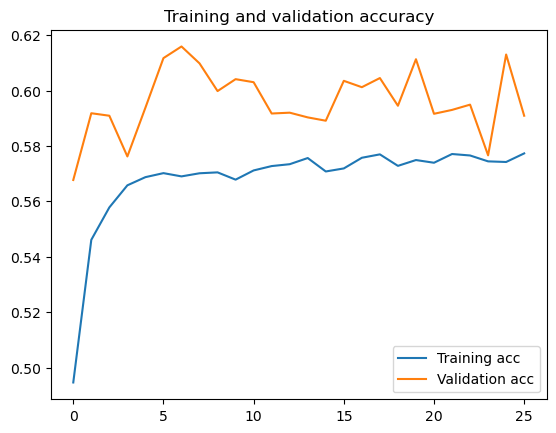

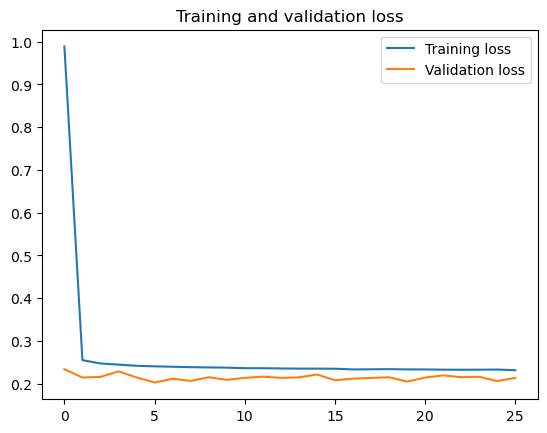

In [51]:
plot_history(history)

Tulostetaan kirjan esimerkki mallin tarkkuus.

In [56]:
full_featured = np.concatenate((train_features, val_features), axis=0)
full_labels = np.concatenate((train_labels, val_labels), axis=0)

model = Sequential([
    keras.Input(shape=(1, 1, 512)),
    layers.Flatten(),
    layers.Dense(256),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

callbacks = [
    ModelCheckpoint(filepath="cifar10.keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=20)
]

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.fit(full_featured, full_labels, epochs=200, validation_data=(test_features, test_labels), verbose=0, callbacks=callbacks)
model = keras.models.load_model("cifar10.keras")

test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f'Test accuracy: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.6027 - loss: 0.2066
Test accuracy: 0.6082


## Malli ylioppimaan
Ensin meidän tavoitteena on vain saada malli, jonka koulutus data menee yli `63%` koska tämä oli meidän tavoite, emmekä voi olettaa että testi data menisi sen yli, jos koulutus data ei edes siihen kykene.
Nostamme paljon dense kerrosten neuroni määrää ja lisäämme myös yhdän dense tason.

In [67]:
model = Sequential([
    keras.Input(shape=(1, 1, 512)),
    layers.Flatten(),
    layers.Dense(2500, activation="relu"),
    layers.Dense(1500, activation="relu"),
    layers.Dense(10, activation="softmax")
])

callbacks = [EarlyStopping(monitor="val_loss", patience=20)]

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
history = model.fit(train_features, train_labels, epochs=200, validation_data=(val_features, val_labels), callbacks=callbacks, verbose=0)

Graafista näemme että koulutus data nousee `80%`, jonka jälkeen se selittämättömästi laskee takaisin lähelle aloitus pistettä. En tiedä mikä ihme tämän aiheuttaa, mutta uskon että kunhan säädämme `EarlyStopping` asetusta lopettamaan koulutuksen aikaisemmin, kaikki pitäisi sujua ongelmitta.

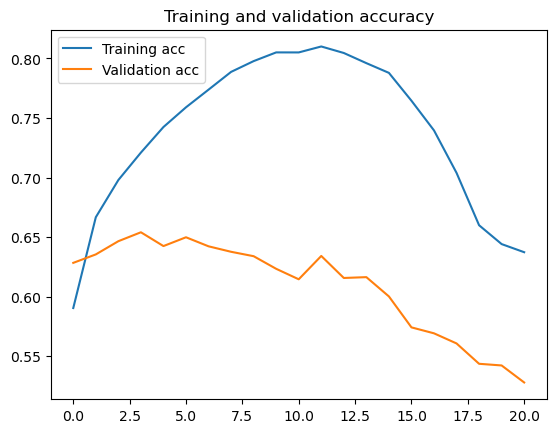

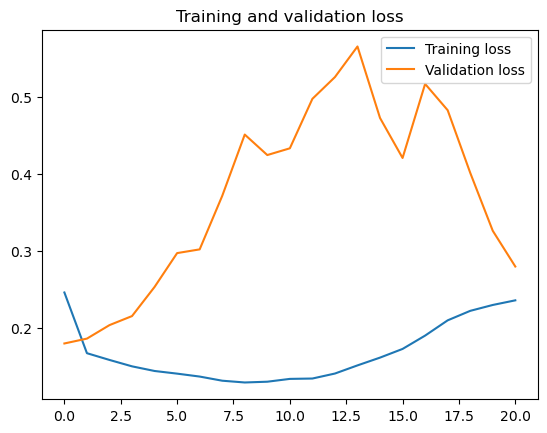

In [68]:
plot_history(history)

### Ylioppimisen midigointi
Yritin yksinkertaista `Dropout` tason lisäystä, joka näyttää hidastavan ylioppimista, joka on hyvä. Laskin myös `EarlyStopping` arvoa kymmeneen, jotta tuota outoa koulutus datan kohdistuvaa alzheimerin iskua ei tapahtuisi.

In [82]:
model = Sequential([
    keras.Input(shape=(1, 1, 512)),
    layers.Flatten(),
    layers.Dense(2500, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2500, activation="relu"),
    layers.Dense(10, activation="softmax")
])

callbacks = [EarlyStopping(monitor="val_loss", patience=10)]

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
history = model.fit(train_features, train_labels, epochs=200, batch_size=64, validation_data=(val_features, val_labels), callbacks=callbacks, verbose=0)

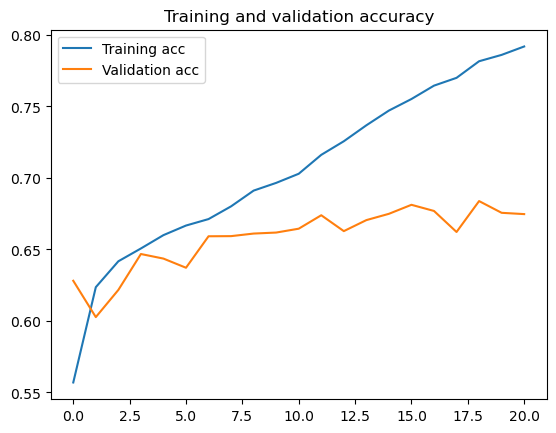

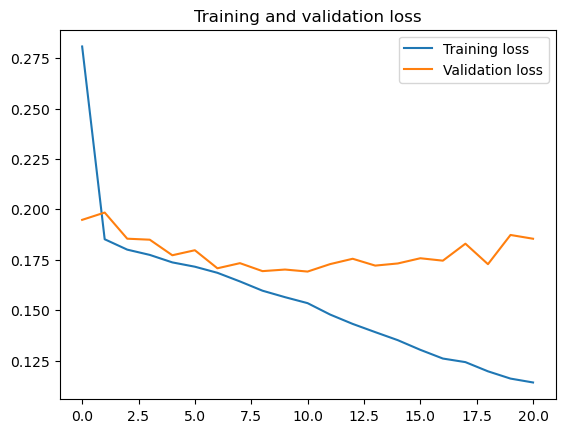

In [83]:
plot_history(history)

Tulostetaan mallin tarkkuun, joka on yli `63%`.

In [84]:
full_featured = np.concatenate((train_features, val_features), axis=0)
full_labels = np.concatenate((train_labels, val_labels), axis=0)

model = Sequential([
    keras.Input(shape=(1, 1, 512)),
    layers.Flatten(),
    layers.Dense(2500, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2500, activation="relu"),
    layers.Dense(10, activation="softmax")
])


callbacks = [
    ModelCheckpoint(filepath="cifar10.keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=10)
]

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.fit(full_featured, full_labels, epochs=200, validation_data=(test_features, test_labels), verbose=0, callbacks=callbacks)
model = keras.models.load_model("cifar10.keras")

test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f'Test accuracy: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6715 - loss: 0.1757
Test accuracy: 0.6703
